# Pulse Scheduling

In [65]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from quantum_circuits import *
from analysis import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Test run of Pulse Hadamard on Belem

In [66]:
from qiskit.pulse.library import Waveform
from qiskit.pulse.channels import DriveChannel, ControlChannel
from qiskit import pulse

In [60]:
#qk.IBMQ.save_account("aaff224a30e77d3ea3af33e2e3fb1cebfbff4e33b04ef75fdbbb9e9055426f547739b68d5b93dac4d47e7828d840a212436b1c36a358f9185574ce60af9a9f53", overwrite=True) 
provider = qk.IBMQ.load_account()
provider = qk.IBMQ.get_provider(hub='ibm-q', group='open', project='main')

ibmqfactory.load_account:WARNING:2023-08-16 14:14:15,747: Credentials are already in use. The existing account in the session will be replaced.


## Custom Pulse schedule gate

The Waveform class allows you to make arbitrary waveform pulses, and is quite powerful and easy to use

In [75]:
#gaussian pulse
def f(x):
    return np.exp(-5*x**2)

x = np.linspace(-1, 1, 1000)

stop = 30*16 # must be multiple of 16 for many backends

waveform = Waveform(f(x[:stop]))

We create a custom pulse acting on two qubits, creating some entanglement. I am unsure exactly what unitary effect this is, but this can be simulated ideally. This pulse is a slice of the gaussian waveform. Each element in the waveform represent of unit of time on the backend (which is often about 1ns).

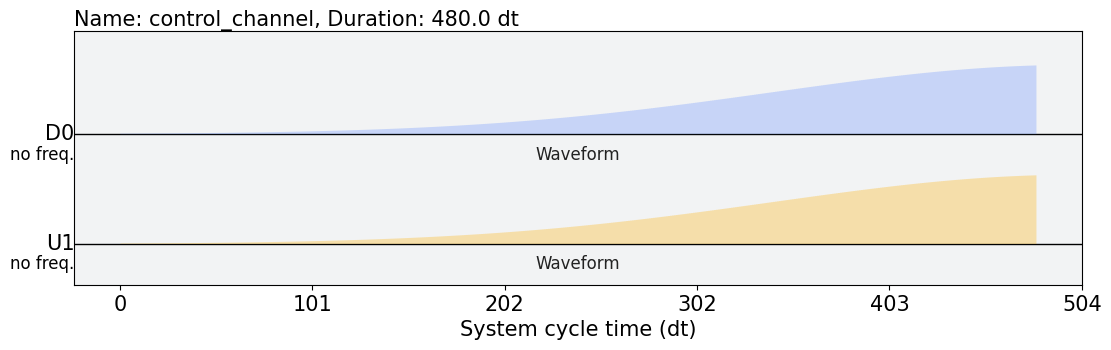

In [81]:
backend = provider.get_backend("ibmq_manila")

# create a custom pulse
with pulse.build(backend, name='control_channel') as custom_pulse:
    pulse.play(waveform, DriveChannel(0))
    pulse.play(waveform, ControlChannel(1))

custom_pulse.draw()

After making the pulse, we define and name a custom gate. We leave the gate undefined, since we will calibrate it to the pulse we just defined.

In [87]:
custom_gate = qk.circuit.Gate('partial_pulse', num_qubits=2, params = [])

circuit = qk.QuantumCircuit(2, 2)

# pauli string
circuit.x(0) 
circuit.y(1)

circuit.append(custom_gate, [0,1])

# another pauli string
circuit.y(0) 
circuit.h(1)

circuit.measure([0,1], [0,1])

Without calibration, the backend will try to decompose the custom gate into its own elementary gates. However, after calibrating the custom gate to the custom pulse, it is treated as a new elementary gate, and its pulse description will be respected: 

In [88]:
circuit.add_calibration('partial_pulse', [0,1], custom_pulse)

Now we can transpile the circuit, and the "partial pulse" gate will have the correct pulse description.

In [89]:
circuit_transpiled = transpile(circuit, backend=backend, optimization_level=0, scheduling_method='alap')

In [90]:
print(circuit_transpiled)

global phase: π/4
                ┌────────────────┐ ┌───┐                             »
      q_0 -> 0 ─┤ Delay(160[dt]) ├─┤ X ├─────────────────────────────»
                └──┬─────────┬───┘ ├───┴┐┌────────┐┌────┐┌──────────┐»
      q_1 -> 1 ────┤ Rz(π/2) ├─────┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├»
               ┌───┴─────────┴────┐└────┘└────────┘└────┘└──────────┘»
ancilla_0 -> 2 ┤ Delay(25200[dt]) ├──────────────────────────────────»
               ├──────────────────┤                                  »
ancilla_1 -> 3 ┤ Delay(25200[dt]) ├──────────────────────────────────»
               ├──────────────────┤                                  »
ancilla_2 -> 4 ┤ Delay(25200[dt]) ├──────────────────────────────────»
               └──────────────────┘                                  »
          c: 2/══════════════════════════════════════════════════════»
                                                                     »
«               ┌────────────────┐   ┌─────────┐       ┌───

In [91]:
job = backend.run(circuit_transpiled, shots = 1000)
result = job.result()
counts = result.get_counts()

In [ ]:
print(counts)